In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker

from alive_progress import alive_bar

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde


# # Defining plotting style:
plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
# Setting plt colors to TU Delft colors (order: blue, red, yellow, green and repeating with different shades):
plt_colors = [
    "#006EB7",
    '#A50034',
    "#64A600",
    "#F97306",
    # Darker colors
    '#1A356E',
    "#E60000",
    '#6CC24A',
    '#FFB81C',
    # More darker colors
    "#000D3A",
    "#9A0000",
    "#B14400",
    "#3D5B00",
]

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set random seed for reproducibility:
np.random.seed(42)
tf.random.set_seed(42)

Num GPUs Available:  1


In [2]:
# Loading the data
telem_path = r"../telemetry-files/funcube-1/funcube-1-telemetry-2016-02-10.h5"
telem_df = pd.read_hdf(
    telem_path,
    "telem",
)

# Adding illumination data:
for i, row in telem_df.iterrows():
    telem_df.loc[i, "illumination"] = 1 if row["theta_T (deg)"] < 360 * (1 - row["fe"]) else 0

# Reordering columns to have illumination after theta_T (deg):
illum_col = telem_df["illumination"].to_numpy()
telem_df = telem_df.drop("illumination", axis=1)
telem_df.insert(loc=6, column="illumination", value=illum_col)

telem_df.head()

time (utc)     time (jd)  beta (deg)        fe  theta (deg)  \
0  2016-02-04 00:00:00.000  2.457422e+06   43.419578  0.314142   287.512192   
1  2016-02-04 00:01:00.000  2.457423e+06   43.419238  0.313883   291.258857   
2  2016-02-04 00:02:00.000  2.457423e+06   43.418972  0.313594   295.003917   
3  2016-02-04 00:03:00.000  2.457423e+06   43.418786  0.313277   298.747190   
4  2016-02-04 00:04:00.000  2.457423e+06   43.418684  0.312933   302.488507   

   theta_T (deg)  illumination  black chassis temperature (deg C)  \
0      50.966681           1.0                               1.23   
1      54.759942           1.0                               1.47   
2      58.556932           1.0                               0.00   
3      62.357285           1.0                               1.68   
4      66.160507           1.0                               3.65   

   silver chassis temperature (deg C)  black panel temperature (deg C)  \
0                               -0.85                            -2.10   
1                                1.17                             2.75   
2                                2.44                             7.00   
3                                1.81                             4.38   
4                                2.77                             6.23   

   silver panel temperature (deg C)  solar panel +X temperature (deg C)  \
0                              2.23                                3.39   
1                              5.04                                0.69   
2                              8.09                               -1.80   
3                              5.67                                2.97   
4                              6.31                                2.14   

   solar panel -X temperature (deg C)  solar panel +Y temperature (deg C)  \
0                               -2.41                               -1.40   
1                                0.92                                2.75   
2                                3.84                               -0.57   
3                                0.50                               -1.40   
4                                0.50                                3.79   

   solar panel -Y temperature (deg C)  
0                                0.43  
1                               -2.91  
2                                1.89  
3                                3.77  
4                                0.22

In [3]:
def normalize_temperature(temps, limits=None):
    """
    Function to normalize the temperature data to the range [0, 1].
    :param temps: Temperature data to be normalized.
    :param limits: Limits of the temperature data. If None, the limits are calculated from the data.

    :return: Normalized temperature data.
    """
    
    if limits is None:
        limits = np.array([np.min(temps), np.max(temps)])

    return (temps - limits[0]) / (limits[1] - limits[0])

def denormalize_temperature(temps, limits):
    """
    Function to denormalize the temperature data to the range [0, 1].
    :param temps: Temperature data to be denormalized.
    :param limits: Limits of the temperature data.

    :return: Denormalized temperature data.
    """

    return temps * (limits[1] - limits[0]) + limits[0]

In [4]:
# Processing the data to remove constant rows and adding illumination data:
telem_processed_df = telem_df.copy()
prev_row = telem_processed_df.loc[0]

for i, row in telem_processed_df.iterrows():
    if i == 0:
        continue
    # Check for same temperature values
    if row.loc[
        "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"
    ].equals(
        prev_row.loc[
            "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"
        ]
    ):
        telem_processed_df.drop(i, inplace=True)
        continue
    # Check for same time
    if (
        row.loc["time (utc)"]
        == prev_row.loc["time (utc)"]
    ):
        telem_processed_df.drop(i, inplace=True)
        continue

    prev_row = row

telem_processed_df = (
    telem_processed_df.reset_index(drop=True)
)

In [5]:
# Splitting the data into training and testing sets
train_df = telem_processed_df[:int(0.8 * len(telem_processed_df))].copy()
test_df = telem_processed_df[int(
    0.8 * len(telem_processed_df)):].copy().reset_index(drop=True)

# Normalizing the data
norm_limits = np.array([np.min(train_df.iloc[:, 7:].to_numpy()), np.max(train_df.iloc[:, 7:].to_numpy())])  # limits of the temperature data calculated only from the training data

train_norm_df = train_df.copy() # copying the training data to a new dataframe
test_norm_df = test_df.copy()   # copying the testing data to a new dataframe

train_norm_df.iloc[:, 7:] = normalize_temperature(train_norm_df.iloc[:, 7:].to_numpy(), norm_limits) # normalizing the training data
test_norm_df.iloc[:, 7:] = normalize_temperature(test_norm_df.iloc[:, 7:].to_numpy(), norm_limits)  # normalizing the testing data


In [6]:
def create_artificial_anomaly(anomalies):
    """
    Function to create artificial anomalies in the data.
    :param anomalies: List of anomalies to be added to the data.

    :return: Dataframe with the anomalies added.
    """

    orbit_before = telem_df.iloc[376:474].drop_duplicates(subset=["theta_T (deg)"], keep="last")    # orbit before the anomaly
    anomaly_orbit = telem_df.iloc[474:572].drop_duplicates(subset=["theta_T (deg)"], keep="last")   # anomaly orbit

    anomaly_df = pd.DataFrame(
        columns=telem_df.columns,
    )   # dataframe to store the anomaly data

    anomaly_df = pd.concat([anomaly_df, orbit_before])  # adding the orbit before the anomaly to the anomaly dataframe

    anomaly_theta_T = anomaly_orbit["theta_T (deg)"].to_numpy() # theta_T values of the anomaly orbit for the interpolation

    normal_temp_interps = [interp1d(
        orbit_before["theta_T (deg)"].to_numpy(),
        orbit_before.iloc[:, 7 + i].to_numpy(),
        kind="cubic",
        fill_value="extrapolate",
    ) for i in range(4)]    # interpolations of the temperature values of the normal orbit

    for i, anomaly in enumerate(anomalies):
        if not anomaly:
            anomaly_orbit.iloc[:, 7 + i] = normal_temp_interps[i](anomaly_theta_T)  # if the anomaly is not present, the temperature values are interpolated from the normal orbit

    anomaly_df = pd.concat([anomaly_df, anomaly_orbit]).reset_index(drop=True)  # adding the anomaly orbit to the anomaly dataframe
    anomaly_df.iloc[:, 7:] = normalize_temperature(anomaly_df.iloc[:, 7:], norm_limits) # normalizing the anomaly data

    return anomaly_df

In [7]:
def window_data_base(df, window_size, return_numpy=True, check_continuity=True):
    """
    Function to create windowed data for the base model.
    :param df: Dataframe to be windowed.
    :param window_size: Size of the window.
    :param return_numpy: Boolean to return the input and output numpy arrays of the model.
    :param check_continuity: Boolean to check for continuity in the data.

    :return: Windowed dataframe (and) numpy arrays of the input and output data.
    """


    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["black chassis temp"],
        ["silver chassis temp"],
        ["black panel temp"],
        ["silver panel temp"],
    ))  # columns of the windowed dataframe

    window_df = pd.DataFrame(
        columns=columns, index=range(len(df) - window_size))

    for i in range(len(window_df)):
        if check_continuity:
            if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60): # ensure that the data is continuous (knowing that the data is sampled at 1 minute intervals)
                continue

        window_df.iloc[i, 0] = df["theta_T (deg)"][i + window_size] # theta_T value of the output
        window_df.iloc[i, 1:window_size + 1] = df.loc[i:i +
                                                      window_size - 1, "illumination"]  # illumination values of the input
        window_df.loc[i,
                      "black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size]  # black chassis temperature of the output
        window_df.loc[i,
                      "silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size]    # silver chassis temperature of the output
        window_df.loc[i,
                      "black panel temp"] = df["black panel temperature (deg C)"][i + window_size]  # black panel temperature of the output
        window_df.loc[i,
                      "silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size]    # silver panel temperature of the output

    window_df = window_df.dropna().reset_index(drop=True)

    if return_numpy:
        # Creating the numpy arrays
        x_data = np.empty(
            shape=(len(window_df), window_size, 1), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, :, 0] = row.iloc[1:window_size + 1]   # input illumination values
            y_data[i, :] = row.iloc[window_size + 1:]   # output temperature values (normalized)

        return window_df, x_data, y_data

    return window_df

In [8]:
def plot_model(theta_T_vals, temp_vals, plt_titles=None, labels=None, colors=None, linestyles=None):
    """
    Function to plot the temperatures vs. theta_T.
    :param theta_T_vals: theta_T values.
    :param temp_vals: Temperature values.
    :param plt_titles: Titles of the plots.
    :param labels: Labels of the plots.
    :param colors: Colors of the plots.
    :param linestyles: Linestyles of the plots.

    :return: None
    """

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    for i in range(2):
        for j in range(2):
            for k in range(temp_vals.shape[0]):
                ax[i, j].plot(
                    theta_T_vals,
                    temp_vals[k, :, i * 2 + j],
                    label=labels[k] if labels is not None else None,
                    color=colors[k] if plt_colors is not None else plt_colors[k],
                    linestyle=linestyles[k] if linestyles is not None else "-",
                )
            
            ax[i, j].set_xlabel(r"$\theta_T$ (deg)")
            ax[i, j].set_ylabel("Temperature (deg C)")
            ax[i, j].set_title(plt_titles[i * 2 + j] if plt_titles is not None else None)
            ax[i, j].legend()
            ax[i, j].grid()

In [9]:
# Function to calculate the kernel density estimate (KDE) of a given dataset:
def kde(data, bins=250, plot_kde=True, labels=None):
    """
    Function to calculate the kernel density estimate (KDE) of a given dataset.
    :param data: Dataset to be used for the KDE.
    :param bins: Number of bins to be used for the KDE.
    :param plot_kde: Boolean to plot the KDE.
    :param labels: Labels of the KDE plots.

    :return: kde, bin_centers
    """

    kde = np.empty(shape=(data.shape[1], bins), dtype=np.float64)   # array to store the KDE values
    bin_centers = np.empty(shape=(data.shape[1], bins), dtype=np.float64)   # array to store the bin centers
    for i in range(data.shape[1]):
        kde_func = gaussian_kde(data[:, i])  # kernel density estimate function
        bin_centers[i] = np.linspace(np.min(data[:, i]), np.max(data[:, i]), bins)  # bin centers
        kde[i, :] = kde_func(bin_centers[i])    # KDE values

    if plot_kde:
        plt.figure(figsize=(5, 5))
        for i in range(data.shape[1]):
            plt.plot(
                bin_centers[i],
                kde[i],
                color=plt_colors[i],
                label=labels[i] if labels is not None else None,
            )

        plt.xlabel(r"Error ($^\circ$C)")
        plt.ylabel(r"Probability density ($^\circ$C$^{-1}$)")
        plt.title("Kernel density estimate of the errors")
        plt.legend()
        plt.grid()
        plt.show()

    return kde, bin_centers



def print_kde_stats(data, kde, bin_centers):
    """
    Function to print the mean, standard deviation and area under the KDE curve of a given dataset.
    :param data: Dataset to be used for the KDE.
    :param kde: KDE values.
    :param bin_centers: Bin centers.

    :return: None
    """

    print("Black panel:")
    print(f"Mean: {np.mean(data[:, 0]):.2f} degC Std: {np.std(data[:, 0]):.2f} degC (area: {np.trapz(kde[0], bin_centers[0]):.2f})")
    print("Silver panel:")
    print(f"Mean: {np.mean(data[:, 1]):.2f} degC Std: {np.std(data[:, 1]):.2f} degC (area: {np.trapz(kde[1], bin_centers[1]):.2f})")
    print("Black chassis:")
    print(f"Mean: {np.mean(data[:, 2]):.2f} degC Std: {np.std(data[:, 2]):.2f} degC (area: {np.trapz(kde[2], bin_centers[2]):.2f})")
    print("Silver chassis:")
    print(f"Mean: {np.mean(data[:, 3]):.2f} degC Std: {np.std(data[:, 3]):.2f} degC (area: {np.trapz(kde[3], bin_centers[3]):.2f})")




In [10]:
class Model:
    """
    Class to hold the model and its training and testing data.

    :param train_x: Training input data.
    :param train_y: Training output data.
    :param test_x: Testing input data.
    :param test_y: Testing output data.
    :param name: Name of the model.
    :param model: Tensorflow model.
    :param run_device: Device to run the model on.
    :param history: History of the model training.
    """

    def __init__(self, train_x, train_y, test_x, test_y, name=None):
        """
        Initialize the model class.
        :param train_x: Training input data.
        :param train_y: Training output data.
        :param test_x: Testing input data.
        :param test_y: Testing output data.
        :param name: Name of the model.

        :return: None
        """

        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.name = name
        self.model = None
        self.run_device = None
        self.history = None


    def create_model(self, layers, optimizer, loss, metrics, input_shape, output_shape):
        """
        Create the model.
        :param layers: List of layers stored as dictionaries with the following keys: type, units, activation.
        :param optimizer: Optimizer function to use for trining.
        :param loss: Loss function to use for training.
        :param metrics: Metrics to use for training.
        :param input_shape: Shape of the input data.
        :param output_shape: Shape of the output data.

        :return: None
        """

        self.model = tf.keras.Sequential(name=self.name)    # create the model
        self.model.add(tf.keras.layers.InputLayer(input_shape=input_shape))   # add the input layer
        self.run_device = "/GPU:0"  # set the device to run the model on

        # Add the layers to the model
        for i, layer in enumerate(layers):
            if layer.get("type") == "LSTM":
                if i < len(layers) - 1:
                    if layers[i + 1].get("type") == "LSTM":
                        self.model.add(
                            tf.keras.layers.LSTM(
                                layer.get("units"),
                                activation=layer.get("activation"),
                                return_sequences=True,
                            )
                        )
                    else:
                        self.model.add(
                            tf.keras.layers.LSTM(
                                layer.get("units"),
                                activation=layer.get("activation"),
                                return_sequences=False,
                            )
                        )
                else:
                    self.model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=False,
                        )
                    )
                if layer.get("activation") == "relu":
                    self.run_device = "/CPU:0"  # if the model uses a ReLU activation function, run it on the CPU
            elif layer.get("type") == "Dense":
                self.model.add(
                    tf.keras.layers.Dense(
                        layer.get("units"), activation=layer.get("activation"),
                    )
                )
            else:
                raise ValueError("Invalid layer type")  # raise an error if the layer type is invalid

        self.model.add(tf.keras.layers.Dense(output_shape, activation="linear"))    # add the output layer

        # Compile the model
        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[metrics],
        )

    
    def train_model(self, epochs, callbacks=None):
        """
        Function to train the model.
        :param epochs: Number of epochs to train the model for.
        :param callbacks: Callbacks to use during training.

        :return: None
        """

        # Train the model
        with tf.device(self.run_device):
            self.history = self.model.fit(
                self.train_x,
                self.train_y,
                epochs=epochs,
                validation_data=(self.test_x, self.test_y),
                callbacks=[callbacks],
            )

        # Plot the training history
        plt.figure(figsize=(5, 5))
        plt.plot(
            np.linspace(1, len(self.history.history["loss"]), len(self.history.history["loss"])),
            self.history.history["loss"],
            color=plt_colors[0],
            label="Training Loss",
        )
        plt.plot(
            np.linspace(1, len(self.history.history["loss"]), len(self.history.history["loss"])),
            self.history.history["val_loss"],
            color=plt_colors[1],
            label="Validation Loss",
        )
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(self.name)
        plt.legend()
        plt.grid()
        plt.show()

In [11]:
base_model_layers = np.empty(shape=(7), dtype=dict,)    # create an array to hold the layers of the base model
base_model_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
base_model_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
base_model_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
base_model_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
base_model_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
base_model_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
base_model_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         264192    
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         525312    
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         197120    
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_5 (LSTM)               (None, None, 32)          12416     
                                                                 
 lstm_6 (LSTM)               (None, 16)                3

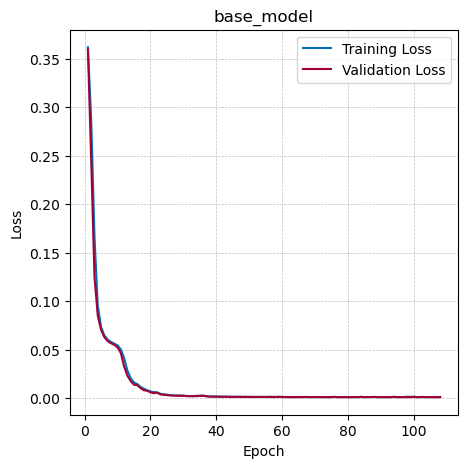

In [12]:
base_train_df, base_train_x, base_train_y = window_data_base(train_norm_df, 97)   # create the training data for the base model
base_test_df, base_test_x, base_test_y = window_data_base(test_norm_df, 97) # create the testing data for the base model

base_model = Model(
    base_train_x,
    base_train_y,
    base_test_x,
    base_test_y,
    name="base_model",
)   # initialize the base model

base_model.create_model(
    base_model_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=(None, 1),
    output_shape=4,
)   # create the base model

base_model.model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
)   # create an early stopping callback

base_model.train_model(250, early_stopping)   # train the base model

4/4 [==============================] - 2s 21ms/step
Base model performance:


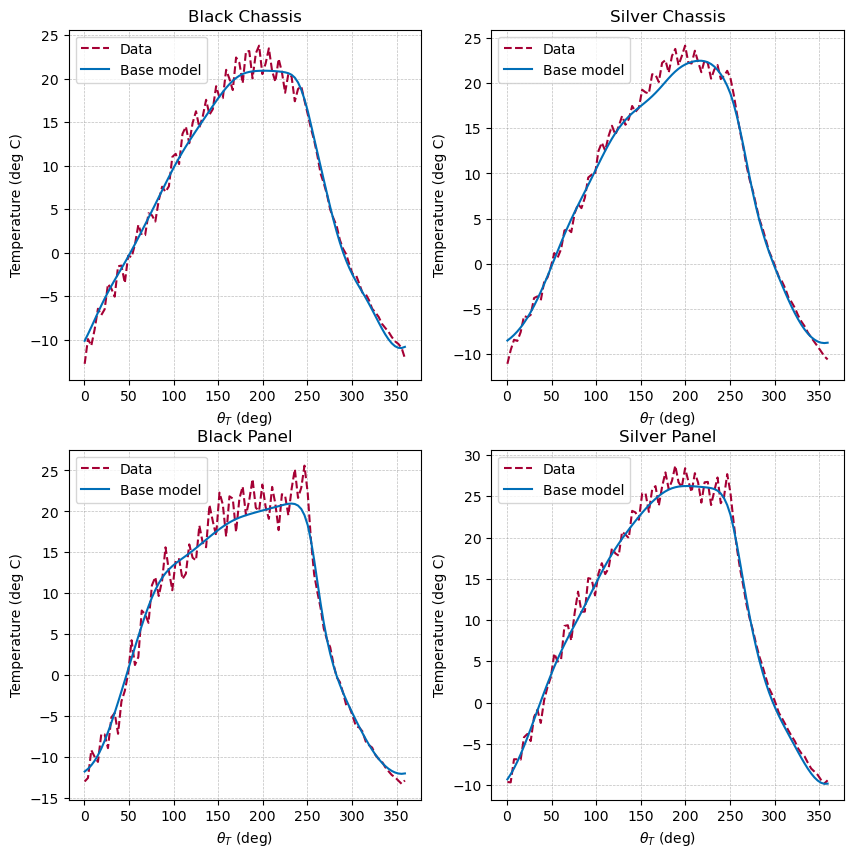

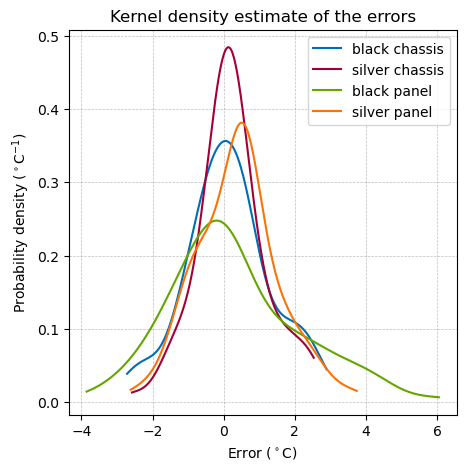

Black panel:
Mean: 0.13 degC Std: 1.19 degC (area: 0.97)
Silver panel:
Mean: 0.23 degC Std: 0.96 degC (area: 0.97)
Black chassis:
Mean: 0.30 degC Std: 1.83 degC (area: 0.99)
Silver chassis:
Mean: 0.38 degC Std: 1.15 degC (area: 0.99)


In [13]:
# Checking performance of the base model:
temp_df = create_artificial_anomaly([False, False, False, False])   # dataframe for orbit with no anomalies
base_eval_df, base_eval_x, base_eval_y = window_data_base(temp_df, 97, check_continuity=False)  # create the evaluation data for the base model

base_preds = base_model.model.predict(base_eval_x)  # get the predictions from the base model

theta_T_vals = base_eval_df["theta_T"].to_numpy()   # theta_T values to plot against
temp_vals = np.empty(shape=(2, base_eval_y.shape[0], base_eval_y.shape[1]), dtype=np.float64)   # array to hold the temperature values
temp_vals[0] = denormalize_temperature(base_eval_y, norm_limits)    # expected temperature values (denormalized)
temp_vals[1] = denormalize_temperature(base_preds, norm_limits) # predicted temperature values (denormalized)

# Plot the temperature values
print("Base model performance:")
plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=["Black Chassis", "Silver Chassis", "Black Panel", "Silver Panel"],
    labels=["Data", "Base model"],
    colors=[plt_colors[1], plt_colors[0]],
    linestyles=["--", "-"],
)

# Evaluating the distribution of the prediction errors
base_kde, base_bin_centers = kde(temp_vals[0]-temp_vals[1], labels=["black chassis", "silver chassis", "black panel", "silver panel"])
print_kde_stats(temp_vals[0]-temp_vals[1], base_kde, base_bin_centers)

In [14]:
def window_data_res(df, base_window_size, res_window_size, base_model, return_numpy=True, check_continuity=True):
    """
    Function to create the data for the residual model.
    :param df: dataframe to create the data from
    :param base_window_size: window size of the base model (illumination data)
    :param res_window_size: window size of the residual model (temperature data)
    :param base_model: base model to use
    :param return_numpy: boolean to return input and output numpy arrays for the model
    :param check_continuity: boolean to check if the data is continuous

    :return: dataframe with the windowed data (and) input numpy array, output numpy array
    """

    # Columns of the residual model dataframe
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(base_window_size)],
        ["input black chassis temp " + str(i) for i in range(res_window_size)],
        ["input silver chassis temp " + str(i) for i in range(res_window_size)],
        ["input black panel temp " + str(i) for i in range(res_window_size)],
        ["input silver panel temp " + str(i) for i in range(res_window_size)],
        ["predicted black chassis temp"],
        ["predicted silver chassis temp"],
        ["predicted black panel temp"],
        ["predicted silver panel temp"],
        ["output black chassis temp"],
        ["output silver chassis temp"],
        ["output black panel temp"],
        ["output silver panel temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - base_window_size))  # create the dataframe

    for i in range(len(window_df)):
        if check_continuity:    
            if df["time (jd)"][i + base_window_size] - df["time (jd)"][i] > (base_window_size + 1.5) / (24 * 60):   # check if the data is continuous (knowing that the data is sampled every 1 minutes)
                continue   # skip the data if it is not continuous

        window_df.iloc[i, 0] = df.loc[i + base_window_size, "theta_T (deg)"]    # set the theta_T value
        window_df.iloc[i, 1:base_window_size + 1] = df.loc[i:i + base_window_size - 1, "illumination"].to_numpy()   # set the illumination values
        window_df.iloc[i, base_window_size + 1:base_window_size + 1 + res_window_size] = df.iloc[i + base_window_size - res_window_size:i + base_window_size, 7].to_numpy()  # set the black chassis temperature values
        window_df.iloc[i, base_window_size + 1 + res_window_size:base_window_size + 1 + 2 * res_window_size] = df.iloc[i + base_window_size - res_window_size:i + base_window_size, 8].to_numpy()   # set the silver chassis temperature values
        window_df.iloc[i, base_window_size + 1 + 2 * res_window_size:base_window_size + 1 + 3 * res_window_size] = df.iloc[i + base_window_size - res_window_size:i + base_window_size, 9].to_numpy()   # set the black panel temperature values
        window_df.iloc[i, base_window_size + 1 + 3 * res_window_size:base_window_size + 1 + 4 * res_window_size] = df.iloc[i + base_window_size - res_window_size:i + base_window_size, 10].to_numpy()  # set the silver panel temperature values

        window_df.loc[i, "output black chassis temp"] = df.iloc[i + base_window_size, 7]    # set the output black chassis temperature value
        window_df.loc[i, "output silver chassis temp"] = df.iloc[i + base_window_size, 8]   # set the output silver chassis temperature value
        window_df.loc[i, "output black panel temp"] = df.iloc[i + base_window_size, 9]  # set the output black panel temperature value
        window_df.loc[i, "output silver panel temp"] = df.iloc[i + base_window_size, 10]    # set the output silver panel temperature value

    window_df = window_df.dropna(how="all").reset_index(drop=True)  # drop the rows with no data

    base_pred_x = window_df.iloc[:, 1:base_window_size + 1].to_numpy(dtype=np.float64)  # get the input data for the base model
    base_pred_x = base_pred_x.reshape((base_pred_x.shape[0], base_pred_x.shape[1], 1))  # reshape the input data for the base model
    base_pred_y = base_model.model.predict(base_pred_x, verbose=0)  # predict the output data for the base model

    window_df.loc[:, "predicted black chassis temp":"predicted silver panel temp"] = base_pred_y    # set the predicted output data for the residual model
    
    if return_numpy:
        # Create the input and output numpy arrays
        x_data = np.empty(shape=(len(window_df), 4 * res_window_size + 5), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i] = row.iloc[base_window_size:-4].to_numpy(dtype=np.float64)    # set the input data
            y_data[i] = (row.iloc[-4:].to_numpy() - row.iloc[-8:-4].to_numpy()) * (norm_limits[1] - norm_limits[0]) # set the output data (actual - predicted) and denormalize it

        return window_df, x_data, y_data

In [15]:
# list of window sizes for the residual model
res_window_sizes = range(1, 11)

# list of residual models
res_models = []

# Residual model layers
res_model_layers = np.empty(shape=(7), dtype=dict,)
res_model_layers[0] = {
    "type": "Dense",
    "units": 256,
    "activation": "relu",
}
res_model_layers[1] = {
    "type": "Dense",
    "units": 256,
    "activation": "relu",
}
res_model_layers[2] = {
    "type": "Dense",
    "units": 128,
    "activation": "relu",
}
res_model_layers[3] = {
    "type": "Dense",
    "units": 128,
    "activation": "relu",
}
res_model_layers[4] = {
    "type": "Dense",
    "units": 64,
    "activation": "relu",
}
res_model_layers[5] = {
    "type": "Dense",
    "units": 32,
    "activation": "relu",
}
res_model_layers[6] = {
    "type": "Dense",
    "units": 16,
    "activation": "relu",
}

# Create the residual models
for res_window_size in res_window_sizes:
    res_train_df, res_train_x, res_train_y = window_data_res(train_norm_df, 97, res_window_size, base_model)    # get the training data
    res_test_df, res_test_x, res_test_y = window_data_res(test_norm_df, 97, res_window_size, base_model)    # get the testing data

    res_model = Model(
        res_train_x,
        res_train_y,
        res_test_x,
        res_test_y,
        name=f"res_model_{res_window_size}",
    )   # initialize the residual model

    res_model.create_model(
        res_model_layers,
        tf.keras.optimizers.Adam(learning_rate=5e-5),
        tf.keras.losses.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
        input_shape=(4 * res_window_size + 5,),
        output_shape=4,
    )   # create the residual model

    res_models.append(res_model)    # add the residual model to the list

Model: "res_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               2560      
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 16)                

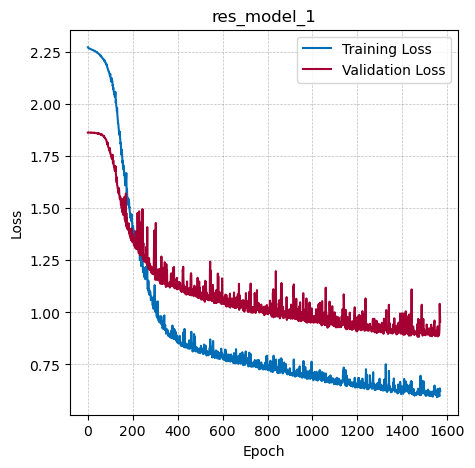

Model: "res_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               3584      
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 16)                

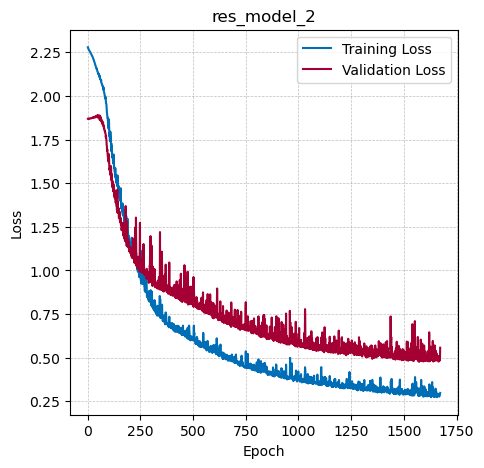

Model: "res_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 256)               4608      
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 16)                

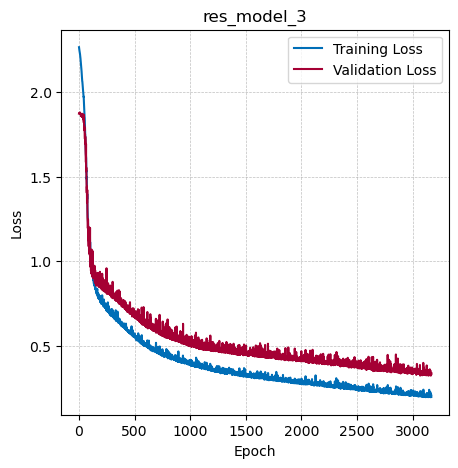

Model: "res_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 256)               5632      
                                                                 
 dense_26 (Dense)            (None, 256)               65792     
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                                 
 dense_28 (Dense)            (None, 128)               16512     
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 dense_31 (Dense)            (None, 16)                

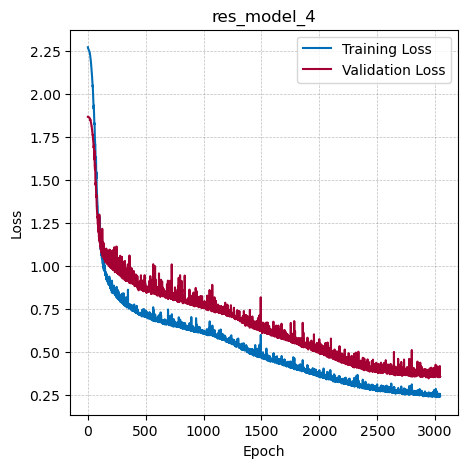

Model: "res_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 256)               6656      
                                                                 
 dense_34 (Dense)            (None, 256)               65792     
                                                                 
 dense_35 (Dense)            (None, 128)               32896     
                                                                 
 dense_36 (Dense)            (None, 128)               16512     
                                                                 
 dense_37 (Dense)            (None, 64)                8256      
                                                                 
 dense_38 (Dense)            (None, 32)                2080      
                                                                 
 dense_39 (Dense)            (None, 16)                

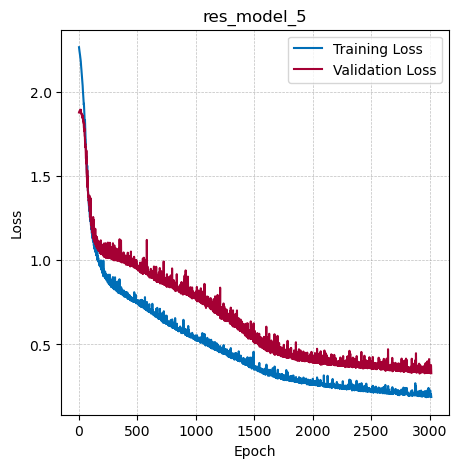

Model: "res_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 256)               7680      
                                                                 
 dense_42 (Dense)            (None, 256)               65792     
                                                                 
 dense_43 (Dense)            (None, 128)               32896     
                                                                 
 dense_44 (Dense)            (None, 128)               16512     
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 16)                

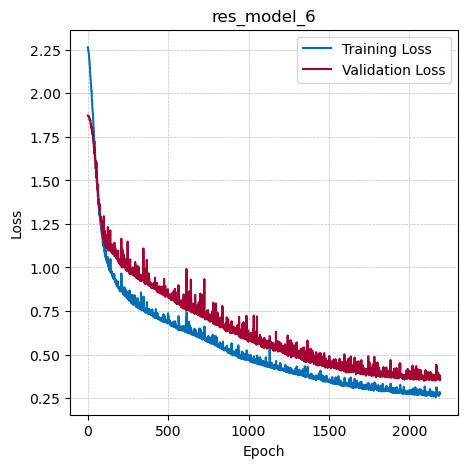

Model: "res_model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 256)               8704      
                                                                 
 dense_50 (Dense)            (None, 256)               65792     
                                                                 
 dense_51 (Dense)            (None, 128)               32896     
                                                                 
 dense_52 (Dense)            (None, 128)               16512     
                                                                 
 dense_53 (Dense)            (None, 64)                8256      
                                                                 
 dense_54 (Dense)            (None, 32)                2080      
                                                                 
 dense_55 (Dense)            (None, 16)                

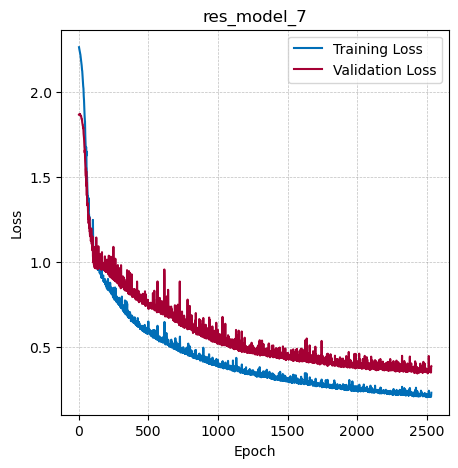

Model: "res_model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 256)               9728      
                                                                 
 dense_58 (Dense)            (None, 256)               65792     
                                                                 
 dense_59 (Dense)            (None, 128)               32896     
                                                                 
 dense_60 (Dense)            (None, 128)               16512     
                                                                 
 dense_61 (Dense)            (None, 64)                8256      
                                                                 
 dense_62 (Dense)            (None, 32)                2080      
                                                                 
 dense_63 (Dense)            (None, 16)                

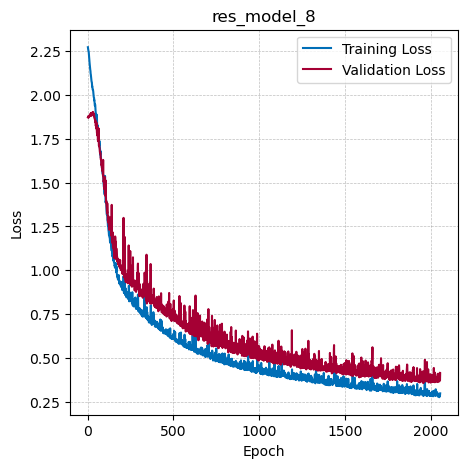

Model: "res_model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 256)               10752     
                                                                 
 dense_66 (Dense)            (None, 256)               65792     
                                                                 
 dense_67 (Dense)            (None, 128)               32896     
                                                                 
 dense_68 (Dense)            (None, 128)               16512     
                                                                 
 dense_69 (Dense)            (None, 64)                8256      
                                                                 
 dense_70 (Dense)            (None, 32)                2080      
                                                                 
 dense_71 (Dense)            (None, 16)                

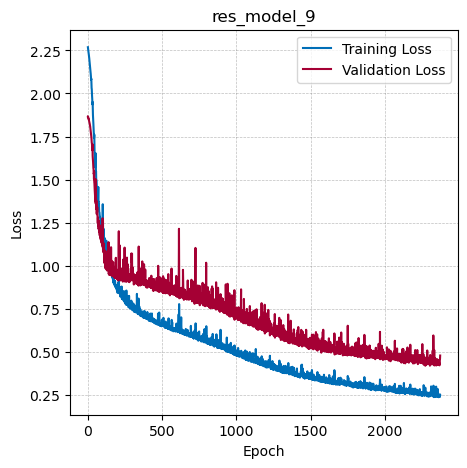

Model: "res_model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 256)               11776     
                                                                 
 dense_74 (Dense)            (None, 256)               65792     
                                                                 
 dense_75 (Dense)            (None, 128)               32896     
                                                                 
 dense_76 (Dense)            (None, 128)               16512     
                                                                 
 dense_77 (Dense)            (None, 64)                8256      
                                                                 
 dense_78 (Dense)            (None, 32)                2080      
                                                                 
 dense_79 (Dense)            (None, 16)               

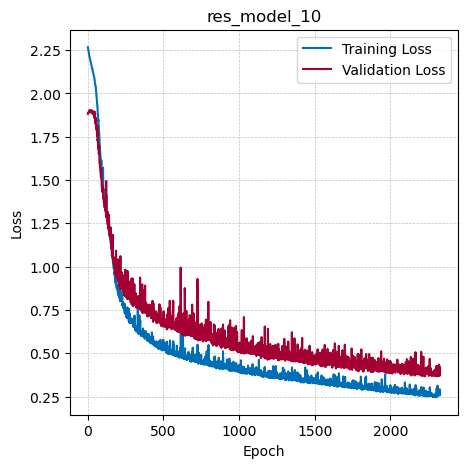

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True,
)   # early stopping callback

# Train all the residual models
for res_model in res_models:
    res_model.model.summary()
    res_model.train_model(5000, early_stopping)

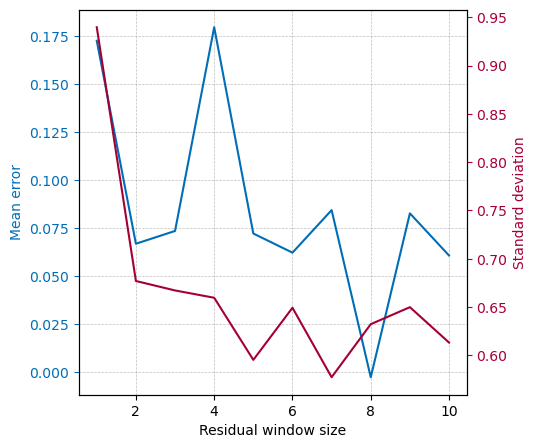

In [17]:
# Evaluating the residual models
mean = np.empty(shape=(len(res_window_sizes)), dtype=np.float64)    # array to store the mean prediction error of the combined model
std = np.empty(shape=(len(res_window_sizes)), dtype=np.float64)   # array to store the standard deviation of the prediction error of the combined model

temp_df = create_artificial_anomaly([False, False, False, False])   # create a dataframe with no anomalies
base_eval_df, base_eval_x, base_eval_y = window_data_base(temp_df, 97, check_continuity=False)  # get the input and output data for the base model
base_pred = base_model.model.predict(base_eval_x, verbose=0)    # base mdodel prediction

for i, res_model in enumerate(res_models):
    res_eval_df, res_eval_x, res_eval_y = window_data_res(temp_df, 97, res_window_sizes[i], base_model, check_continuity=False)   # get the input and output data for the residual model
    res_pred = res_model.model.predict(res_eval_x, verbose=0)   # residual model prediction
    combined_pred = denormalize_temperature(base_pred, norm_limits) + res_pred  # combined model prediction
    errors = denormalize_temperature(base_eval_y, norm_limits) - combined_pred  # prediction error
    mean[i] = np.mean(errors)   # mean prediction error
    std[i] = np.std(errors) # standard deviation of the prediction error


# Plot the mean prediction error and standard deviation of the combined model for different residual window sizes
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax_twin = ax.twinx()
ax.plot(
    res_window_sizes,
    mean,
    color=plt_colors[0],
)
ax_twin.plot(
    res_window_sizes,
    std,
    color=plt_colors[1],
)
ax.set_xlabel("Residual window size")
ax.set_ylabel("Mean error", color=plt_colors[0])
ax_twin.set_ylabel("Standard deviation", color=plt_colors[1])
ax.grid()
ax.tick_params(axis="y", colors=plt_colors[0])
ax_twin.tick_params(axis="y", colors=plt_colors[1])